# Introduction

In this notebook, we will explore how to build a machine learning model for classifying images using PyTorch, a widely used and acclaimed deep learning library. PyTorch has become a popular choice among researchers and machine learning practitioners because of its dynamic approach and flexibility for building and training complex models.

One of the distinct advantages of PyTorch is its focus on dynamic programming. Unlike some other deep learning libraries, PyTorch allows you to build and modify computational graphs on the fly, providing great flexibility for designing models and performing interactive experiments. In addition, PyTorch has a large user community and detailed documentation, making it easy to learn and troubleshoot.

Throughout this notebook, we will discover how to take full advantage of PyTorch's capabilities to build, train and evaluate our image classification model. From data preparation to implementing optimization techniques, we will explore the essential fundamentals so that you can develop your skills in the exciting field of machine learning with PyTorch. This notebook follows a basic machine learning workflow

### Index
1. Data Loading: CIFAR10
2. Data Visualization
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data


### 1. Data Loading: CIFAR10

importat text to consider

1. [torchvision](https://pytorch.org/vision/stable/index.html) library
2. [torchvision.datasets](https://pytorch.org/vision/stable/datasets.html)
3. [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html) module




In [ ]:
#title Load Data Cifar10

import torch
import torchvision
import time
import random
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load and transform data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

# preload

train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

Files already downloaded and verified
Files already downloaded and verified


### 2. Data Visualization


important to consider

Dataset description
1. Amount of images
2. size of images
3. amount of classes, which classes?

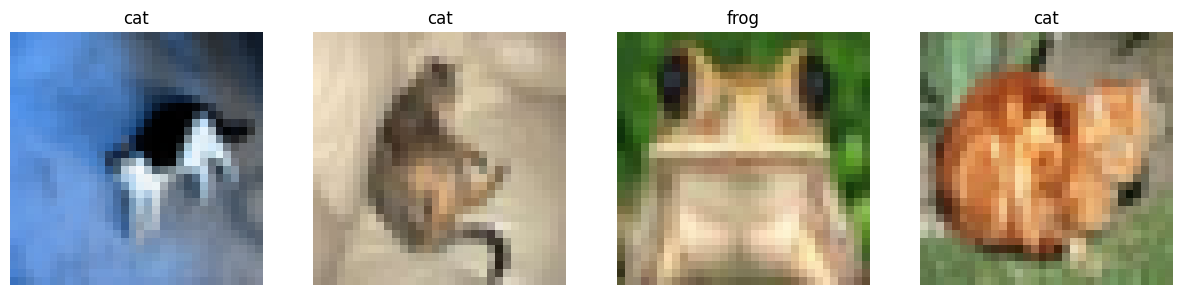

In [ ]:
# visualize data with labels

import matplotlib.pyplot as plt
import numpy as np

# get classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)
# get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for image, i in zip(images, range(4)):

    # show images
    image = imshow(image)
    axs[i].imshow(image)
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')


## 2. Convolutional Neural Network



important to consider:

1. [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)

--------------------

The model consists of the following components:

`Input Layer`: Accepts 3-channel (RGB) images as input.

`Convolutional Layers`: The network starts with a convolutional layer called [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) followed by [batch normalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html). Then, a configurable number of additional convolutional layers are added, each followed by batch normalization and a [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu) activation function. These layers capture hierarchical features from the input images.

`Max Pooling`: After each convolutional layer, [max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) is performed to downsample the feature maps, reducing their spatial dimensions.

`Flattening`: The feature maps are flattened into a 1D vector to be processed by the fully connected layers.

`Fully Connected Layers`: A single [fully connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) is added, which takes the flattened feature vector as input. The output size of this layer is determined by the number of target classes (in this case, 10 classes). The fully connected layer is followed by a [softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax) activation function to obtain class probabilities.

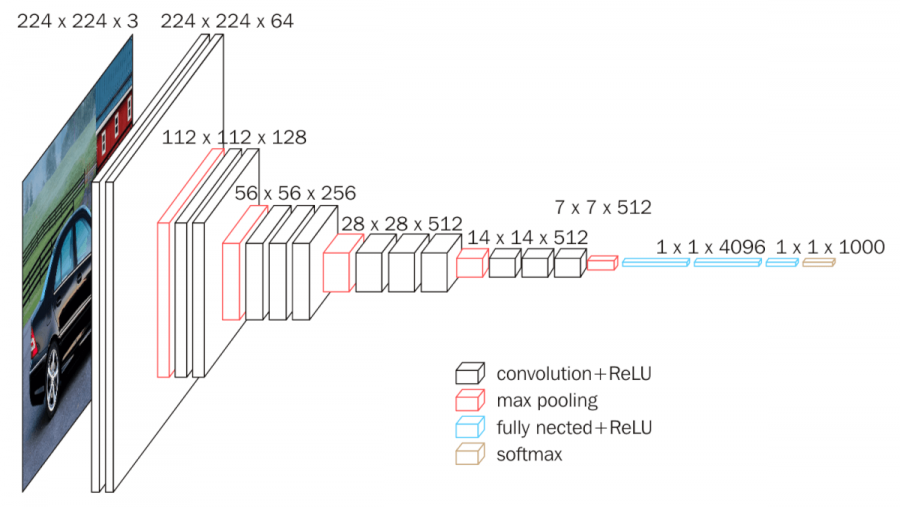

In [ ]:
# Classification model ResNet18 based

import torch.nn as nn

class ClassificationNet(nn.Module):


    # description: what means and what can i do in the __init__ function?
    def __init__(self, features=16, num_layers=4, img_size=32):
        super(ClassificationNet, self).__init__()

        # define layers
        layers = []

        down_factor = 1

        # first layer
        layers.append(nn.Conv2d(3, features, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(features))

        # hidden layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            down_factor *= 2

        layers.append(nn.Flatten())

        final_size = int(img_size / down_factor)

        # output layer
        layers.append(nn.Linear(features * final_size * final_size, 10))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

     # description: what means and what can i do in the forward function?
    def forward(self, x):
        return self.model(x)

In [ ]:
# Crear modelo

model = ClassificationNet()

[Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)

In [ ]:
criterion = nn.CrossEntropyLoss()

important to consider: [toch.optim](https://pytorch.org/docs/stable/optim.html)

1. Ejemplos optimizadores
2. Parametros comunes de los optimizadores (learning rate, weight_decay)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Utilities functions

In [ ]:
def load_data(batch_size=512, pre_load=True):
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
  testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

  if pre_load:
    train_data = [ sample for sample in trainloader ]
    test_data  = [ sample for sample in testloader  ]
    return train_data, test_data
  return trainloader, testloader

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.vals, self.avg, self.sum, self.count = [], 0, 0, 0

  def update(self, val, n=1):
    self.vals.append(val)
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


In [ ]:
# top1 accuracy
def accuracy(output, target, topk=(1,)):
    '''Computes the accuracy over the k top predictions for the specified values of k'''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res

### Validation

In [ ]:

def validate(test_loader, model, criterion):
    model.eval()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(test_loader):

        data_time.update(time.time() - end)

        image, label = image.to(device), label.to(device)

        output = model(image)
        loss = criterion(output, label)
        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()
        top1.update(prec1, image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print(f'Test: \tTime {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
        f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
        f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
        f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')

    return losses.avg, top1.avg

### Train function


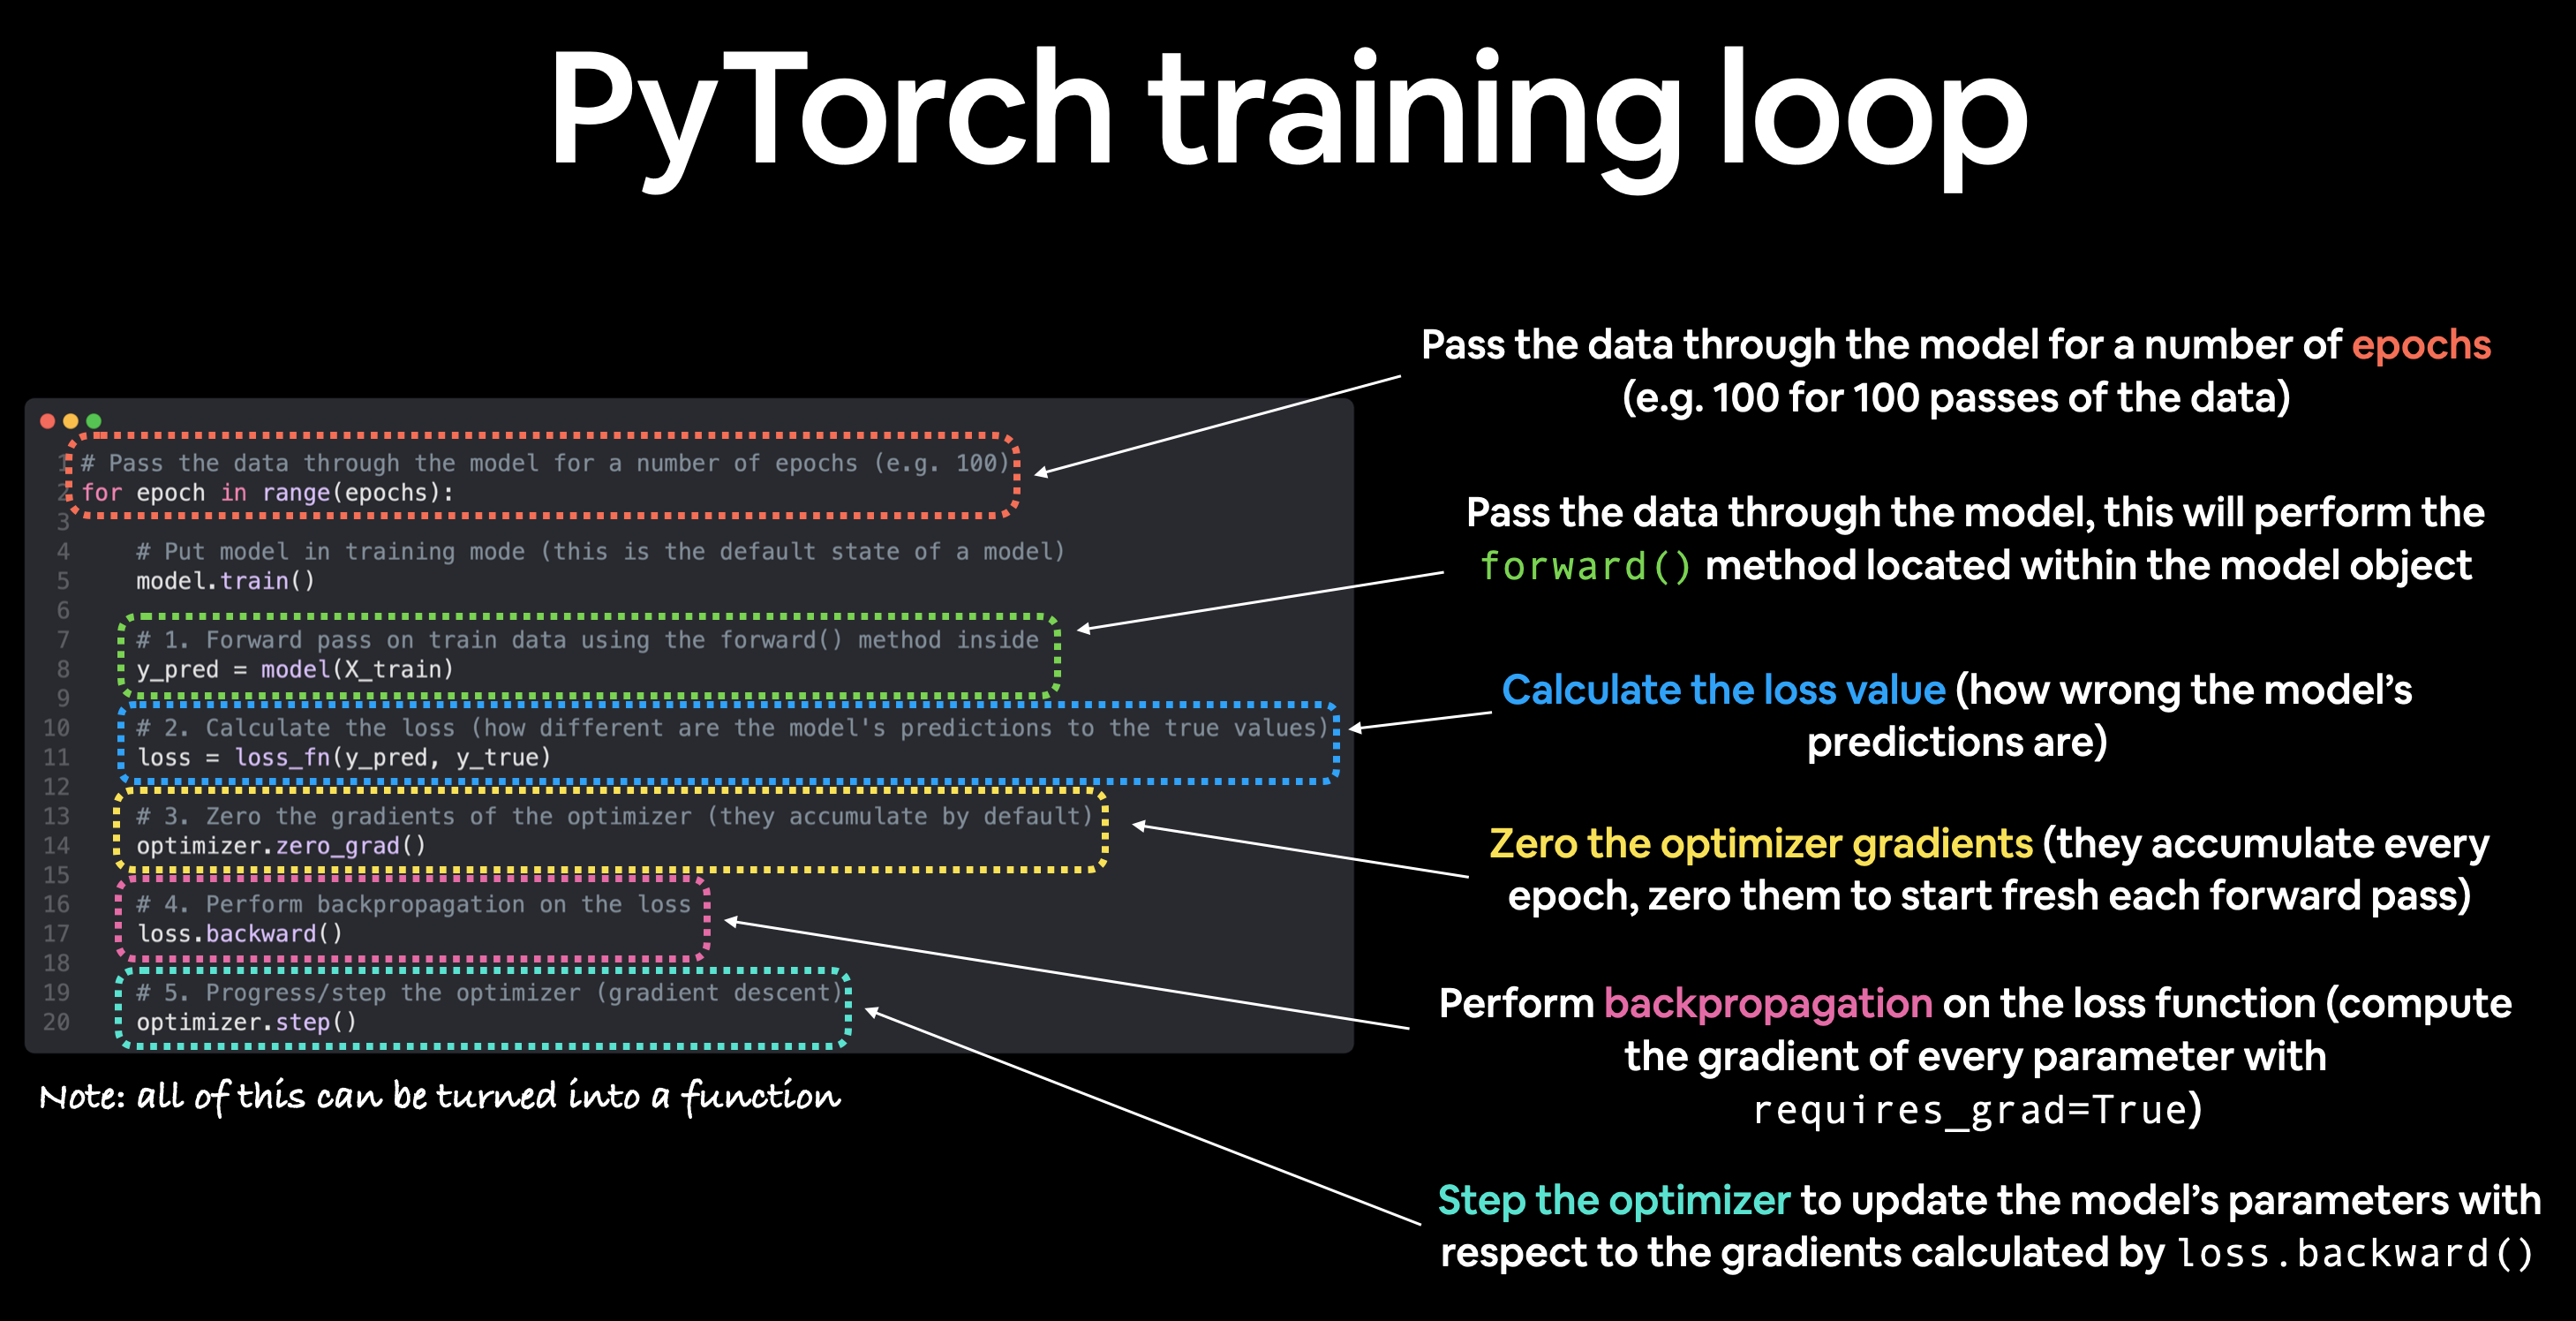

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, verbose=True):
    random.shuffle(train_loader)

    print('Starting training epoch {}'.format(epoch))
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()

        image, label = image.to(device), label.to(device)

        data_time.update(time.time() - end)

        with torch.cuda.amp.autocast(dtype=torch.float16):
          output = model(image)
          loss = criterion(output, label)

        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()

        top1.update(prec1, image.size(0))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0 and verbose:

            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                f'Time {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
                f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
                f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
                f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')


    return losses.vals, top1.vals

In [ ]:
# Move model and loss function to GPU to accelerate computation
criterion = criterion.to(device)
model = model.to(device)

In [ ]:
# train model for 1000 epochs

epochs = 2
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history['loss'].extend(losses)
    history['acc'].extend(acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


history['name'] = model.__class__.__name__

Starting training epoch 0
Epoch: [0][0/98]	Time 1.576 (1.576)	Data 0.004 (0.004)	Loss 2.3151 (2.3151)	Accuracy 8.398 (8.398)
Epoch: [0][50/98]	Time 0.013 (0.047)	Data 0.002 (0.002)	Loss 2.1445 (2.2166)	Accuracy 34.766 (26.002)
Test: 	Time 0.016 (0.020)	Data 0.000 (0.000)	Loss 2.0532 (2.0587)	Accuracy 44.388 (44.960)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.016 (0.016)	Data 0.002 (0.002)	Loss 2.0566 (2.0566)	Accuracy 44.336 (44.336)
Epoch: [1][50/98]	Time 0.013 (0.013)	Data 0.002 (0.002)	Loss 1.9613 (2.0126)	Accuracy 55.273 (49.321)
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9288 (1.9364)	Accuracy 56.505 (55.400)


In [ ]:
# this is just for test
# ignore this cell

epochs = 2
history_2 = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'name': ""
}

for epoch in range(epochs):

    losses, acc  = train(train_data, model, criterion, optimizer, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history_2['loss'].extend(losses)
    history_2['acc'].extend(acc)
    history_2['val_loss'].append(val_loss)
    history_2['val_acc'].append(val_acc)

history_2['name'] = model.__class__.__name__

Starting training epoch 0
Epoch: [0][0/98]	Time 0.017 (0.017)	Data 0.004 (0.004)	Loss 1.9309 (1.9309)	Accuracy 55.078 (55.078)
Epoch: [0][50/98]	Time 0.013 (0.013)	Data 0.002 (0.002)	Loss 1.8962 (1.9069)	Accuracy 58.984 (58.880)
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9053 (1.8951)	Accuracy 57.143 (58.690)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.017 (0.017)	Data 0.002 (0.002)	Loss 1.8500 (1.8500)	Accuracy 64.453 (64.453)
Epoch: [1][50/98]	Time 0.014 (0.014)	Data 0.002 (0.002)	Loss 1.8634 (1.8590)	Accuracy 61.719 (62.783)
Test: 	Time 0.013 (0.019)	Data 0.000 (0.000)	Loss 1.8733 (1.8594)	Accuracy 61.097 (61.970)


In [ ]:
def acc_barplot(history,ax):
    """
    this function plots the training and testing history for n models in a barplot

    Parameters:
    -----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics
    """

    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy of Models (Train vs Test)')

    models = [ f'{e["name"]}' for i, e in enumerate(history) ]
    #check repeated name values
    models = [ models[i] + '_' if models[i] in models[:i] else models[i] for i in range(len(models)) ]

    accs = [ model['acc'][-1] for model in history ]
    val_accs = [ model['val_acc'][-1] for model in history ]
    acc = accs + val_accs

    hue_labels = ['train'] * len(accs) + ['test'] * len(val_accs)

    sns.set(style="whitegrid")
    sns.barplot(x=models * 2, y=acc, hue=hue_labels, ax=ax)



In [ ]:
def batch_lineplot(history, ax):
    """
    This function plots the training and testing history for n models

    Parameters:
    ----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc', 'name'
        each model must have the same number of epochs and metrics

    """

    ax.set_xlabel('Batch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy of Models (Train vs Test)')

    accs = [ model['acc'] for model in history ]

    val_accs = [ model['val_acc'] for model in history ]

    sns.set(style="whitegrid")


    for i,acc in enumerate(accs):
        sns.lineplot(x=range(len(acc)), y=acc, label=f'{history[i]["name"][0]}', ax=ax)

    plt.gca().set_prop_cycle(None) # restar color cycle

    for i, val_acc in enumerate(val_accs):
        sns.lineplot(x=range( len(accs[0])//(len(val_acc)), len(accs[0])+1, len(accs[0])//(len(val_acc))), y=val_acc, label=f'{history[i]["name"][0]} (test)'
                     , marker='o', markersize=7, linestyle='--',  ax=ax)



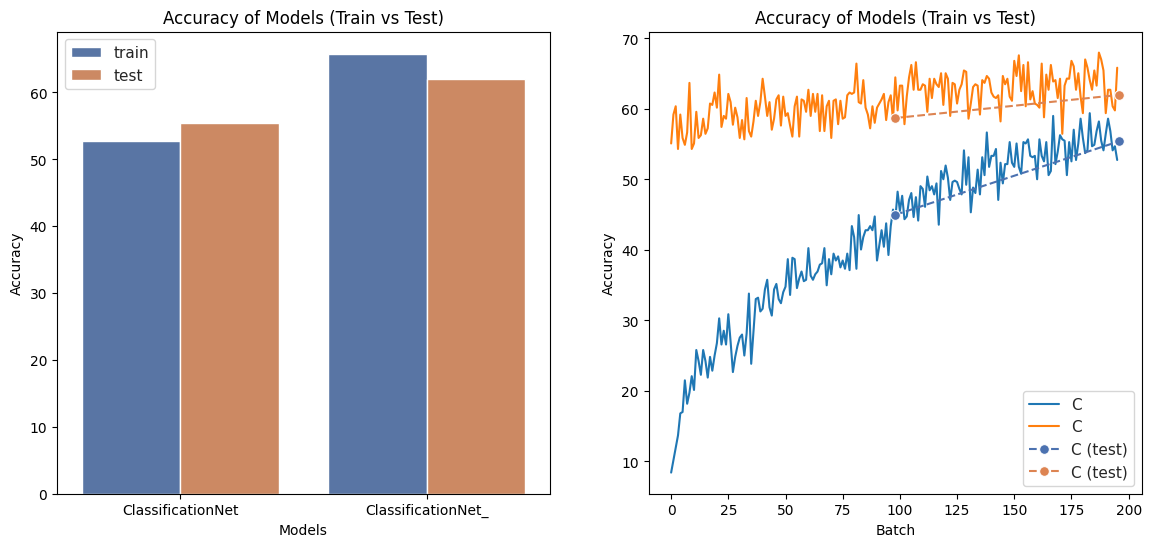

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

acc_barplot(np.array([history,history_2]), ax1)
batch_lineplot(np.array([history,history_2]), ax2)


## hyperparameter tuning

In [ ]:
def tuning_model(parameter, historys, train_data, test_data, optimizer = None,  model = ClassificationNet() ):
    """
    this is an auxiliar function to tune hyperparameters of a model
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) if optimizer is None else optimizer

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    model = model.to(device)

    epochs = 3
    history = {
        'loss': [],
        'acc': [],
        'val_loss': [],
        'val_acc': [],
        'name': ""
    }

    for epoch in range(epochs):

        losses, acc  = train(train_data, model, criterion, optimizer, epoch, verbose=False)

        with torch.no_grad():
            val_loss, val_acc = validate(test_data, model, criterion)

        history['loss'].extend(losses)
        history['acc'].extend(acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

    history['name'] = str(parameter)

    if isinstance(parameter, torch.optim.Optimizer):
        history['name'] = parameter.__class__.__name__

    return history

### batch tuning

In [ ]:
batch_sizes = [ 32, 128, 256 ]

historys = []

for batch_size in batch_sizes:

        train_data, test_data = load_data(batch_size=batch_size)
        history = tuning_model(batch_size, historys, train_data, test_data)
        historys.append(history)

Starting training epoch 0
Test: 	Time 0.014 (0.021)	Data 0.000 (0.000)	Loss 1.8859 (1.8863)	Accuracy 58.418 (58.880)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8607 (1.8541)	Accuracy 59.694 (61.110)
Starting training epoch 2
Test: 	Time 0.014 (0.021)	Data 0.000 (0.000)	Loss 1.8300 (1.8229)	Accuracy 63.010 (64.320)
Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8113 (1.7954)	Accuracy 65.944 (67.240)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8160 (1.7989)	Accuracy 64.286 (66.510)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.8004 (1.7886)	Accuracy 66.582 (67.520)
Starting training epoch 0
Test: 	Time 0.014 (0.018)	Data 0.000 (0.000)	Loss 1.7939 (1.7738)	Accuracy 67.219 (69.080)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.7819 (1.7691)	Accuracy 68.495 (69.560)
Starting training epoch 2
Test: 	Time 0.014 (0.018)	Data 0.000 (

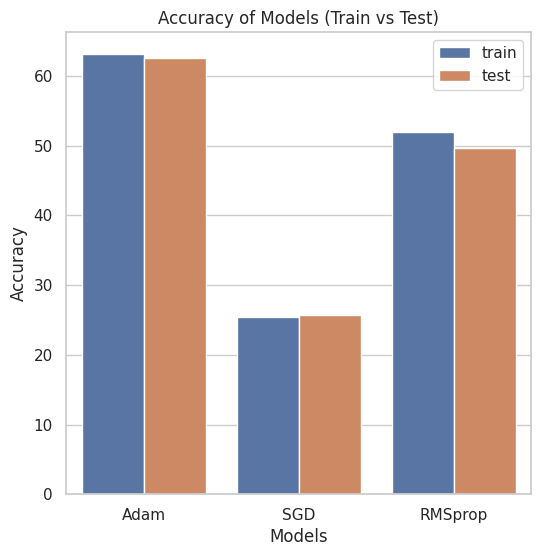

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

acc_barplot(np.array(historys), ax = ax)


### learning rate tuning

In [ ]:
lrs = [ 0.0001, 0.001, 0.01, 0.1 ]

historys = []
train_data, test_data = load_data(batch_size=512)


for lr in lrs:
            model = ClassificationNet()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            history = tuning_model(lr, historys, train_data, test_data, optimizer, model)
            historys.append(history)


Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.2463 (2.2504)	Accuracy 21.173 (21.130)
Starting training epoch 1
Test: 	Time 0.015 (0.019)	Data 0.000 (0.000)	Loss 2.1991 (2.2033)	Accuracy 28.316 (27.460)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.1579 (2.1655)	Accuracy 37.117 (35.080)
Starting training epoch 0
Test: 	Time 0.014 (0.020)	Data 0.000 (0.000)	Loss 2.0212 (2.0315)	Accuracy 47.194 (46.370)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9422 (1.9426)	Accuracy 54.082 (54.660)
Starting training epoch 2
Test: 	Time 0.015 (0.019)	Data 0.000 (0.000)	Loss 1.8905 (1.8879)	Accuracy 59.439 (59.730)
Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.0104 (2.0137)	Accuracy 44.643 (44.090)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9594 (1.9491)	Accuracy 48.980 (50.740)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (

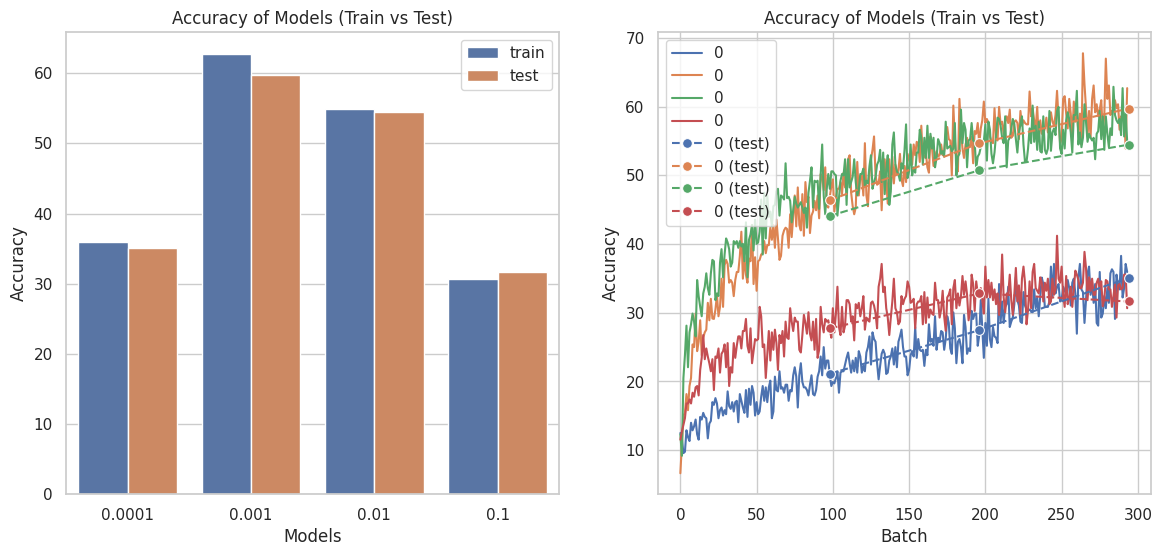

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

acc_barplot(np.array(historys), ax = ax1)
batch_lineplot(np.array(historys), ax = ax2)

### optimizer tuning

In [ ]:
optimizers = [ torch.optim.Adam,
               torch.optim.SGD,
               torch.optim.RMSprop ]

historys = []
train_data, test_data = load_data(batch_size=512)

for optimizer in optimizers:
    model = ClassificationNet()
    optimizer = optimizer(model.parameters(), lr=0.01)
    history = tuning_model(optimizer, historys, train_data, test_data, optimizer, model)
    historys.append(history)


Starting training epoch 0
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9928 (2.0169)	Accuracy 46.939 (44.120)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 1.9344 (1.9234)	Accuracy 52.934 (53.720)
Starting training epoch 2
Test: 	Time 0.015 (0.020)	Data 0.000 (0.000)	Loss 1.8429 (1.8353)	Accuracy 62.500 (62.600)
Starting training epoch 0
Test: 	Time 0.015 (0.020)	Data 0.000 (0.000)	Loss 2.2833 (2.2833)	Accuracy 17.474 (18.280)
Starting training epoch 1
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.2609 (2.2596)	Accuracy 23.214 (23.390)
Starting training epoch 2
Test: 	Time 0.014 (0.019)	Data 0.000 (0.000)	Loss 2.2417 (2.2389)	Accuracy 25.128 (25.670)
Starting training epoch 0
Test: 	Time 0.014 (0.020)	Data 0.000 (0.000)	Loss 2.0526 (2.0544)	Accuracy 41.071 (40.370)
Starting training epoch 1
Test: 	Time 0.014 (0.020)	Data 0.000 (0.000)	Loss 2.0095 (1.9947)	Accuracy 44.133 (46.390)
Starting training epoch 2
Test: 	Time 0.015 (0.019)	Data 0.000 (

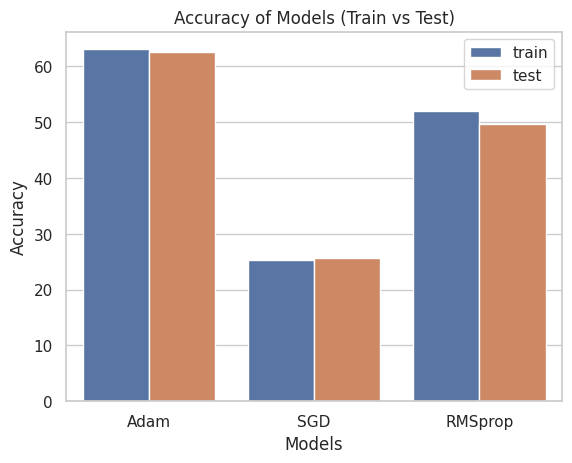

In [ ]:
fig, ax = plt.subplots()
acc_barplot(np.array(historys), ax=ax)